In [1]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from torchvision import transforms, datasets
import torch.backends.cudnn as cudnn

import time
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import math
from scipy.special import softmax

from networks import ResNet
from utils import *
from utils_plotting import *

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
use_cuda = torch.cuda.is_available()

cuda:0


In [3]:
batch_size = 128
mean = (0.4914, 0.4822, 0.4465)
std = (0.2023, 0.1994, 0.2010)

transform_train = transforms.Compose([transforms.RandomHorizontalFlip(),
                                    transforms.RandomCrop(32, padding=4),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean, std)
                                    ])
transform_test = transforms.Compose([transforms.ToTensor(),
                                    transforms.Normalize(mean, std)])

trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
valset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=4)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False, num_workers=4)

print(trainset.train_data.shape)

models_dir = "Models/" + 'Regular_models'
results_dir = "Results/" + 'Regular_results'

Files already downloaded and verified
Files already downloaded and verified
(50000, 32, 32, 3)


## Network

In [4]:
# net = RegularNN(lr=lr, channels_in=3, side_in=32, cuda=use_cuda, classes=10, batch_size=batch_size)
net = ResNet(18, 10)

## Training

In [5]:
net.cuda()
# if use_cuda:
#     net.cuda()
#     net = torch.nn.DataParallel(net, device_ids=range(torch.cuda.device_count()))
#     cudnn.benchmark = True

ResNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential

In [6]:
criterion = nn.CrossEntropyLoss()

def train(epoch): 
    net.train()
    train_loss = 0
    correct = 0
    total = 0

    lr = 0.1
    
    optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate(lr, epoch), momentum=0.9, weight_decay=5e-4)

    print('\n=> Training Epoch #%d, LR=%.4f' %(epoch, learning_rate(lr, epoch)))
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        if use_cuda:
            inputs, targets = inputs.cuda(), targets.cuda() # GPU settings
        optimizer.zero_grad()
        inputs, targets = Variable(inputs), Variable(targets)
        outputs = net(inputs)               # Forward Propagation
        loss = criterion(outputs, targets)  # Loss
        loss.backward()  # Backward Propagation
        optimizer.step() # Optimizer update

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += predicted.eq(targets.data).cpu().sum()

        # sys.stdout.write('\r')
        # sys.stdout.write('| Epoch [%3d/%3d] Iter[%3d/%3d]\t\tLoss: %.4f Acc@1: %.3f%%'
        #         %(epoch, num_epochs, batch_idx+1,
        #             (len(trainset)//batch_size)+1, loss.item(), 100.*correct/total))
        # sys.stdout.flush()
    print('| Epoch [%3d/%3d] Iter[%3d/%3d]\t\tLoss: %.4f Acc@1: %.3f%%'
                %(epoch, num_epochs, batch_idx+1,
                    (len(trainset)//batch_size)+1, loss.item(), 100.*correct/total))

def test(epoch):
    global best_acc
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(valloader):
        if use_cuda:
            inputs, targets = inputs.cuda(), targets.cuda()
        with torch.no_grad():
            inputs, targets = Variable(inputs), Variable(targets)
        outputs = net(inputs)
        loss = criterion(outputs, targets)

        test_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += predicted.eq(targets.data).cpu().sum()

    # Save checkpoint when best model
    acc = 100.*correct/total
    print("\n| Validation Epoch #%d\t\t\tLoss: %.4f Acc@1: %.2f%%" %(epoch, loss.item(), acc))

    if acc > best_acc:
        best_acc = acc
        print('| Saving Best model...\t\t\tTop1 = %.2f%%' %(acc))

        # state = {
        #         'net':net.module if use_cuda else net,
        #         'acc':acc,
        #         'epoch':epoch,
        # }

        # torch.save(state, models_dir + '/' + 'theta_best.t7')
        torch.save(net.state_dict(),models_dir + '/' + 'theta_best.pt')
        


In [7]:
num_epochs = 200
best_acc = 0.5

start = time.time()
elapsed_time = 0
for epoch in range(num_epochs):
    start_time = time.time()

    train(epoch)
    test(epoch)

    epoch_time = time.time() - start_time
    elapsed_time += epoch_time
    print('| Elapsed time : %d:%02d:%02d'  %(get_hms(elapsed_time)))

print('\n[Phase 4] : Testing model')
print('* Test results : Acc@1 = %.2f%%' %(best_acc))
end = time.time()
print('| Total time : %d:%02d:%02d'  %(get_hms(end - start)))


=> Training Epoch #0, LR=0.1000
| Epoch [  0/200] Iter[391/391]		Loss: 1.1508 Acc@1: 39.454%

| Validation Epoch #0			Loss: 1.4439 Acc@1: 47.09%
| Saving Best model...			Top1 = 47.09%
| Elapsed time : 0:00:10

=> Training Epoch #1, LR=0.1000
| Epoch [  1/200] Iter[391/391]		Loss: 1.0760 Acc@1: 57.626%

| Validation Epoch #1			Loss: 1.2685 Acc@1: 54.58%
| Saving Best model...			Top1 = 54.58%
| Elapsed time : 0:00:20

=> Training Epoch #2, LR=0.1000
| Epoch [  2/200] Iter[391/391]		Loss: 0.8412 Acc@1: 65.528%

| Validation Epoch #2			Loss: 1.3813 Acc@1: 55.69%
| Saving Best model...			Top1 = 55.69%
| Elapsed time : 0:00:30

=> Training Epoch #3, LR=0.1000
| Epoch [  3/200] Iter[391/391]		Loss: 0.6507 Acc@1: 70.684%

| Validation Epoch #3			Loss: 0.8233 Acc@1: 69.36%
| Saving Best model...			Top1 = 69.36%
| Elapsed time : 0:00:40

=> Training Epoch #4, LR=0.1000
| Epoch [  4/200] Iter[391/391]		Loss: 0.6554 Acc@1: 74.094%

| Validation Epoch #4			Loss: 0.5819 Acc@1: 68.29%
| Elapsed time

In [8]:
#89.11+
#91.48 / 91.77

## Inference

In [5]:
checkpoint = torch.load(models_dir + '/' + 'theta_best.t7')
net = checkpoint['net']

### Rotations

In [10]:
# rotations, Bayesian

x_dev = []
y_dev = []
for x, y in valloader:
    x_dev.append(x.cpu().numpy())
    y_dev.append(y.cpu().numpy())

x_dev = np.concatenate(x_dev)
y_dev = np.concatenate(y_dev)
print(x_dev.shape)
print(y_dev.shape)

(10000, 3, 32, 32)
(10000,)


(16, 3, 32, 32)


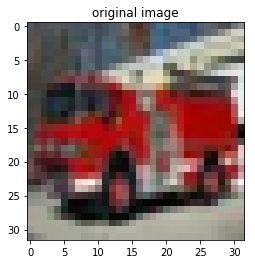

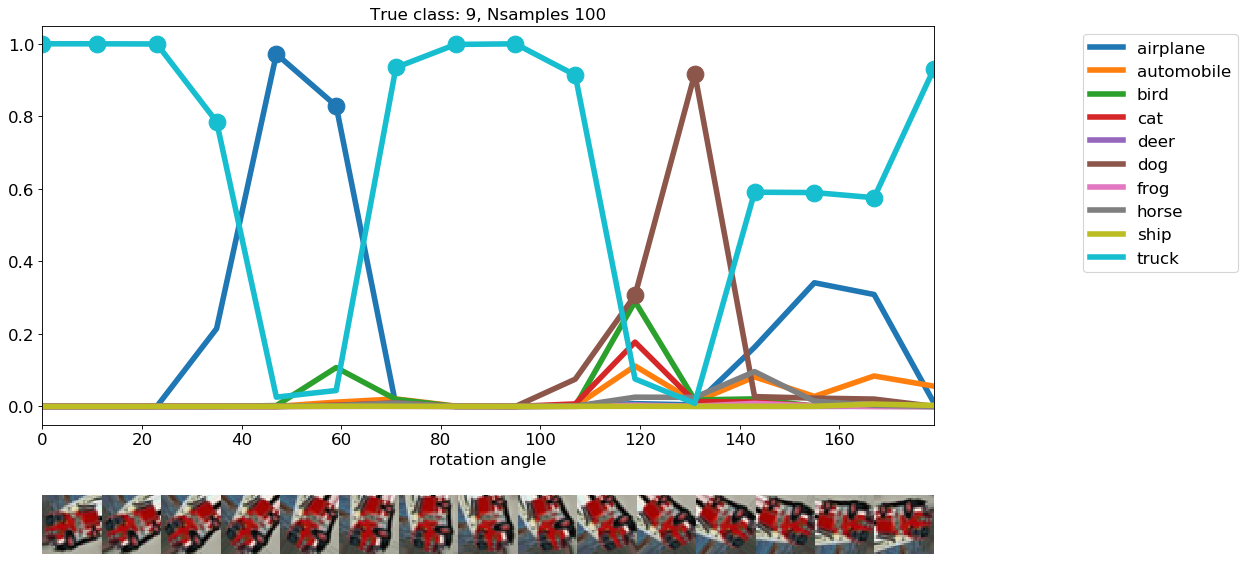

In [11]:
plot_rotate(x_dev, y_dev, net, results_dir, im_list = valset.test_data,im_ind = 23, Nsamples = 100, steps=16)

In [12]:
data_rotated = np.load("data/CIFAR10_rotated.npy")
# data_rotated = np.transpose(data_rotated, (0,1,4,2,3))
data_rotated.shape

(16, 10000, 32, 32, 3)

In [13]:
steps = 16
N = 10000
Nsamples = 5
y_dev = valset.test_labels

def preprocess_test(X):

    N, H, W, C = X.shape
    Y = torch.zeros(N, C, H, W)
    mean = (0.4914, 0.4822, 0.4465)
    std = (0.2023, 0.1994, 0.2010)  
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean,std),
    ])

    for n in range(len(X)):
        Y[n] =  transform_test(X[n])

    return Y

all_preds = np.zeros((N, steps, 10))
all_sample_preds = np.zeros((N, Nsamples, steps, 10))

for im_ind in range(N):
    if(im_ind % 500 == 0):
        print(im_ind)

    y =  y_dev[im_ind]
    
    ims = data_rotated[:,im_ind,:,:,:]
    ims = preprocess_test(ims)

    y = np.ones(ims.shape[0])*y
    
    with torch.no_grad():
        sample_probs = net.all_sample_eval(ims, torch.from_numpy(y), Nsamples=Nsamples)
    probs = sample_probs.mean(dim=0)
    
    all_sample_preds[im_ind, :, :, :] = sample_probs.cpu().numpy()
    predictions = probs.cpu().numpy()
    all_preds[im_ind, :, :] = predictions

0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500


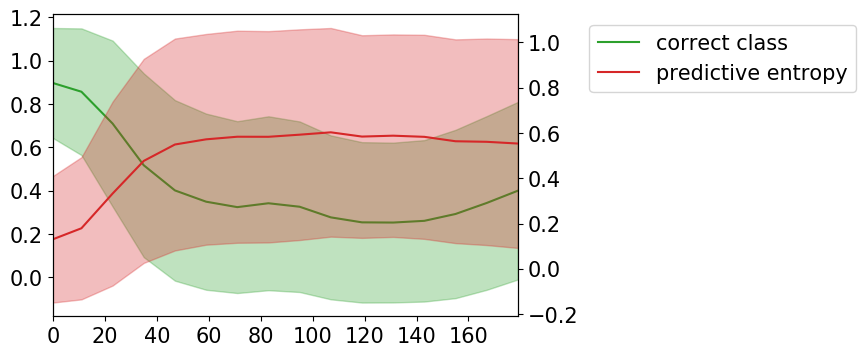

In [15]:
rotations = (np.linspace(0, 179, steps)).astype(int)

correct_preds = np.zeros((N, steps))
for i in range(N):
    correct_preds[i,:] = all_preds[i,:,y_dev[i]]   

np.save(results_dir+'/correct_preds.npy', correct_preds)
np.save(results_dir+'/all_preds.npy', all_preds)
np.save(results_dir+'/all_sample_preds.npy', all_sample_preds)

plot_predictive_entropy(correct_preds, all_preds, rotations, results_dir)

## CIFAR-10-C

In [8]:
chalPath = 'data/CIFAR-10-C/'
chals = sorted(os.listdir(chalPath))

chal_labels = valset.test_labels
chal_labels = torch.Tensor(chal_labels)
chal_labels = chal_labels.long()

def preprocess_test(X):

    N, H, W, C = X.shape
    Y = torch.zeros(N, C, H, W)
    mean = (0.4914, 0.4822, 0.4465)
    std = (0.2023, 0.1994, 0.2010)  
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean,std),
    ])

    for n in range(len(X)):
        Y[n] =  transform_test(X[n])

    return Y

preds_list= []
net.eval()
avg_list = []

for challenge in range(len(chals)):
    chal_data = np.load(chalPath + chals[challenge])
    # chal_data = np.transpose(chal_data, (0,3,1,2))

    avg = 0
    for j in range(5):
        chal_temp_data = chal_data[j * 10000:(j + 1) * 10000]
        chal_temp_data = preprocess_test(chal_temp_data)

        chal_dataset = torch.utils.data.TensorDataset(chal_temp_data, chal_labels)
        chal_loader = torch.utils.data.DataLoader(chal_dataset, batch_size=100)
        chal_error = 0

        with torch.no_grad():
            for x, y in chal_loader:
                cost, err, probs = net.sample_eval(x, y, Nsamples=10, logits=False)
                preds_list.append(probs.cpu().numpy())
                chal_error += err.cpu().numpy()
                # print(err)

        # print(chal_error)
        chal_acc = 1 - (chal_error/len(chal_dataset))
        avg += chal_acc
        print(chal_acc)
    
    avg /= 5
    avg_list.append(avg)
    print("Average:",avg," ", chals[challenge])

print("Mean: ", np.mean(avg_list))

0.9105
0.9065
0.8974
0.8863
0.8526
Average: 0.8906599999999999   brightness.npy
0.9004
0.8405
0.7677
0.6159
0.24129999999999996
Average: 0.67316   contrast.npy
0.909
0.8911
0.8253
0.7163999999999999
0.495
Average: 0.76736   defocus_blur.npy
0.8479
0.8464
0.7902
0.7069
0.6551
Average: 0.7693000000000001   elastic_transform.npy
0.9059
0.8854
0.8528
0.7928
0.5745
Average: 0.80228   fog.npy
0.8409
0.7749
0.6604
0.6408
0.5237
Average: 0.6881400000000001   frost.npy
0.9087
0.8240000000000001
0.7008
0.5656
0.3498
Average: 0.66978   gaussian_blur.npy
0.6769000000000001
0.4527
0.2834
0.22870000000000001
0.19979999999999998
Average: 0.36829999999999996   gaussian_noise.npy
0.46030000000000004
0.486
0.5158
0.38260000000000005
0.41300000000000003
Average: 0.45153999999999994   glass_blur.npy
0.7635000000000001
0.6377999999999999
0.5352
0.3456
0.19799999999999995
Average: 0.49602   impulse_noise.npy
0.8206
0.7637
0.7463
0.7196
0.6824
Average: 0.7465200000000001   jpeg_compression.npy
0.8441
0.74059

In [9]:
preds_list1 = np.vstack(preds_list)
preds_list1.shape

(950000, 10)

In [10]:
np.save(results_dir+'/preds_CIFAR-10-C.npy', preds_list1)
np.save(results_dir+'/avg_list_CIFAR-10-C.npy', avg_list)

(11169152,)


Text(0.5, 1.0, 'Total parameters: 11169152')

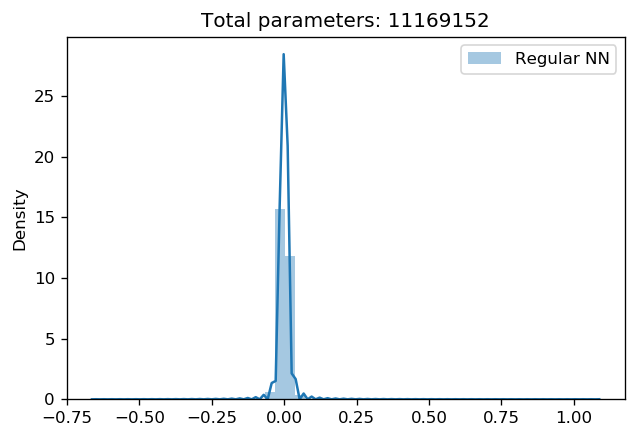

In [22]:
# Weight histogram

name = 'Regular NN'
# mkdir('weight_samples')
weight_vector = net.get_weight_samples()
np.save(results_dir+'/weight_samples_'+name+'.npy', weight_vector)

print(weight_vector.shape)

fig = plt.figure(dpi=120)
ax = fig.add_subplot(111)

sns.distplot(weight_vector, norm_hist=False, label=name, ax=ax)
# ax.hist(weight_vector, bins=70, density=True);

ax.set_ylabel('Density')
ax.legend()
plt.title('Total parameters: %d' % len(weight_vector))

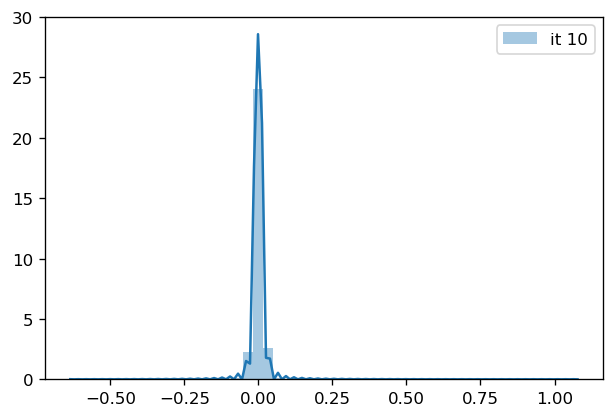

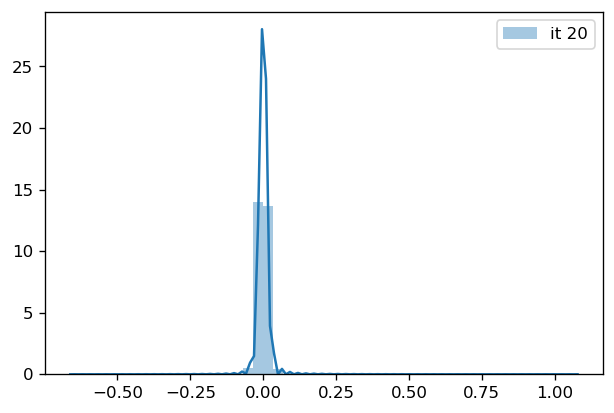

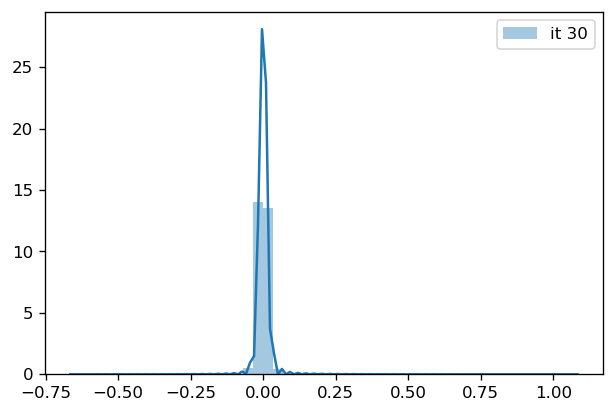

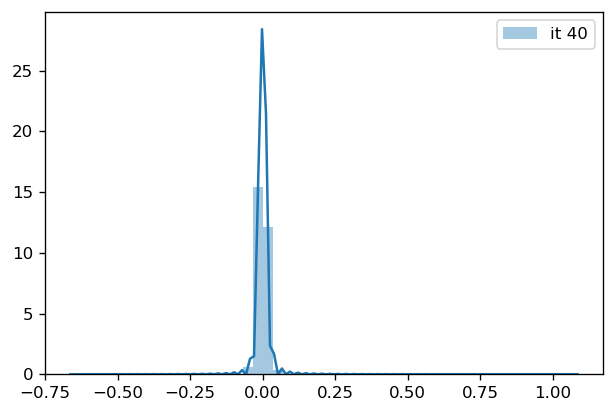

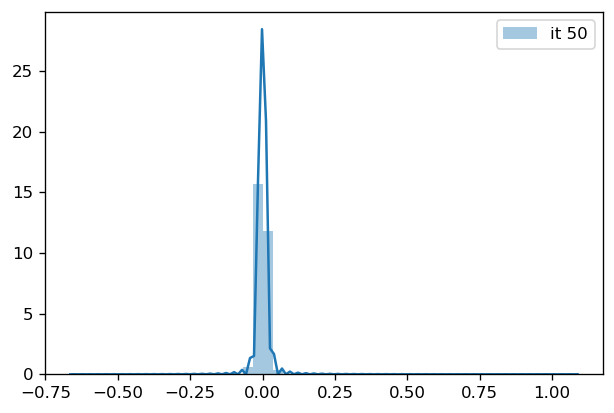

In [23]:
# Evolution over iterations

for idx, iteration in enumerate(savemodel_its):
    
    net.model.load_state_dict(save_dicts[idx])
    weight_vector = net.get_weight_samples()
    fig = plt.figure(dpi=120)
    ax = fig.add_subplot(111)
    symlim = 1
    lim_idxs = np.where(np.logical_and(weight_vector>=symlim, weight_vector<=symlim))
    sns.distplot(weight_vector, norm_hist=False, label='it %d' % (iteration), ax=ax)
    ax.legend()
